In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [41]:
btc = yf.download('BTC-USD')['Adj Close'].to_frame()

[*********************100%%**********************]  1 of 1 completed


Media mobile degli ultimi $N$ giorni:

$SMA_t = \frac{PRICE_{t-1}}{N} + \dots + \frac{PRICE_{t-N}}{N}$

Si può fare calcolando la media, mediana, minimo, massimo.

In [44]:
btc_ma = btc.copy()
btc_ma['SMA50']=btc['Adj Close'].rolling(window=50, min_periods=20).mean()
btc_ma['SMA200']=btc['Adj Close'].rolling(window=200, min_periods=100).mean()

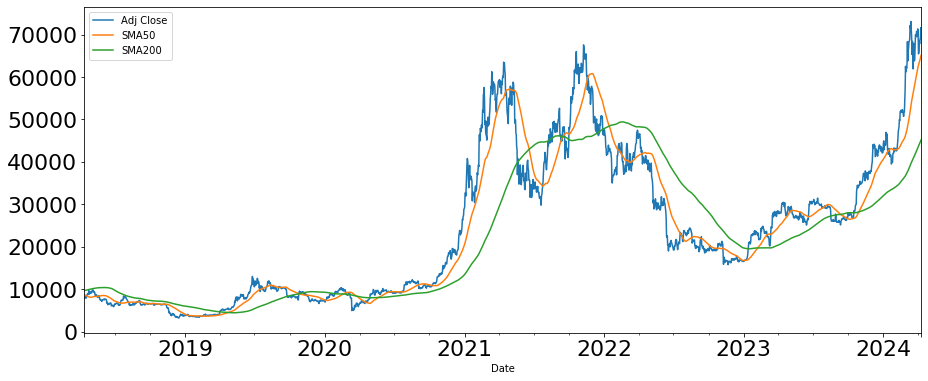

In [45]:
years=6
btc_ma[-365*years:].plot(figsize=(15,6), fontsize=22)

Quando prezzo supera la media mobile, segnale di acquisto, quando scende sotto è un segnale di vendita.

Media esponenziale:

$EMA_t = PRICE_{t-1}\frac{2}{span+1} + EMA_{t-1} \frac{span-1}{span+1}$

Media esponenziale ha una sorta di memoria del passato poichè a differenza della media mobile che considera solo i dati della finestra, la media esponenziale di oggi dipende dalla media esponenziale calcolata il giorno prima e così via. Il parametro $span$ permette di dare un peso diverso al valore di prezzo del giorno prima e la media mobile precedente. 

In [67]:
btc_ma = btc.copy()
btc_ma['SMA100']=btc['Adj Close'].rolling(window=100, min_periods=50).mean()
btc_ma['EMA100']=btc['Adj Close'].ewm(span=100, min_periods=50).mean()

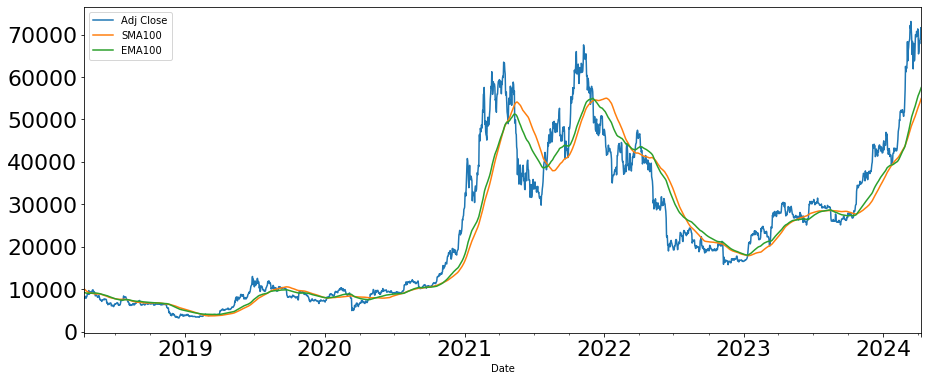

In [68]:
years=6
btc_ma[-365*years:].plot(figsize=(15,6), fontsize=22)

In [94]:
def trading_strategy(df):
    assert 'Adj Close' in df.columns, '[Adj Close] must be in the columns name'
    assert 'MA' in df.columns, '[MA] must be in the columns name'
    
    trade = False
    
    signal = []
    
    gain = 0
    
    
    for idx in df.index:
        if trade == False and df.loc[idx, 'Adj Close']<df.loc[idx, 'MA']:
            signal.append(0)
        elif trade == False and df.loc[idx, 'Adj Close']>=df.loc[idx, 'MA']:
            trade = True
            signal.append(1)
            gain -= df.loc[idx, 'Adj Close']
        elif trade == True and df.loc[idx, 'Adj Close']>df.loc[idx, 'MA']:
            signal.append(0)
        elif trade == True and df.loc[idx, 'Adj Close']<=df.loc[idx, 'MA']:
            trade = False
            signal.append(-1)
            gain += df.loc[idx, 'Adj Close']
            
    if trade == True:
        trade = False
        gain += df.iloc[-1]['Adj Close']
        signal[-1] = -1
        
    return signal, gain
            

In [149]:
def do_the_trade(df, ma_type, window):
    df_copy = df.copy()
    if ma_type == 'simple':
        df_copy['MA']=df_copy['Adj Close'].rolling(window=window).mean()
    else:
        df_copy['MA']=df_copy['Adj Close'].ewm(span=window).mean()
    df_copy.dropna(inplace=True)
    signal, gain = trading_strategy(df_copy)
    return signal, gain

In [163]:
ma_type = 'simple' # simple, exp
windows = [5, 10, 20, 30, 50, 75, 100, 125, 150, 200]

results = {}

for window in windows:
    signal, gain = do_the_trade(btc, ma_type, window)
    results[window] = {'signal':signal, 'gain':gain}

In [164]:
def max_gain_key(outer_dict):
    max_key = None
    max_gain = float('-inf')  # Initialize with negative infinity
    
    for key, inner_dict in outer_dict.items():
        if 'gain' in inner_dict:
            if inner_dict['gain'] > max_gain:
                max_key = key
                max_gain = inner_dict['gain']
    
    return max_key

optimal_window = max_gain_key(results)

In [165]:
btc_copy = btc.copy()
if ma_type == 'simple':
    btc_copy['MA']=btc_copy['Adj Close'].rolling(window=optimal_window).mean()
else:
    btc_copy['MA']=btc_copy['Adj Close'].ewm(span=optimal_window).mean()
#btc_copy['MA']=btc_copy['Adj Close'].ewm(span=100, min_periods=10).mean()
#btc_copy['MA']=btc_copy['Adj Close'].rolling(window=200).mean()
btc_copy.dropna(inplace=True)
#signal, gain = trading_strategy(btc_copy)
btc_copy['signal'] = results[optimal_window]['signal']

In [166]:
def plot_trade(df):
    plt.figure(figsize=(15, 6))
    df['Adj Close'].plot()
    df['MA'].plot()

    # Adding triangles for 'gain' values
    for index, row in df.iterrows():
        if row['signal'] == 1:
            plt.scatter(index, row['MA'], color='green', marker='^', s=100)
        elif row['signal'] == -1:
            plt.scatter(index, row['MA'], color='red', marker='v', s=100)
    plt.show()

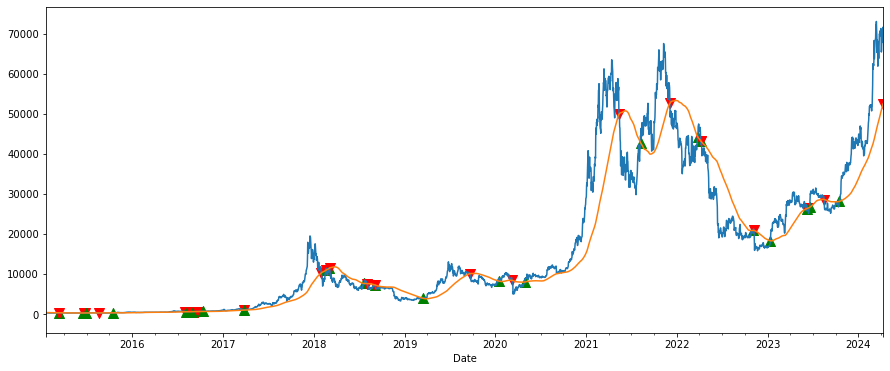

Total gain is:  100323.14


In [167]:
plot_trade(btc_copy)
print('Total gain is: ', round(results[optimal_window]['gain'],2))